In [ ]:
!pip install pydot==1.2.4 kaggle  Pillow
!pip install coremltools==0.8 Keras==2.1.3 imutils==0.4.6 opencv-python==3.4.1.15
!pip install tqdm
!apt-get update && apt-get install graphviz -y


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import numpy as np
import PIL
import os

In [3]:
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger

/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

In [5]:
kaggle_token="""
{"username":"npatta01","key":"61ebcf3b4a3fc7ebfe7aee570d8dc07c"}
"""

In [6]:
!pwd

/home/ubuntu/custom/keras


In [7]:
KAGGLE_PATH=os.path.expanduser("~/.kaggle")
KAGGLE_PATH

'/home/ubuntu/.kaggle'

In [ ]:
!mkdir -p {KAGGLE_PATH}
!echo {json.dumps(kaggle_token)} > {KAGGLE_PATH}/kaggle.json
!chmod 600 {KAGGLE_PATH}/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification


In [ ]:
!ls {KAGGLE_PATH}/competitions/dog-breed-identification


In [ ]:
!ls {KAGGLE_PATH}/competitions/dog-breed-identification/*.zip


In [8]:
PATH = KAGGLE_PATH + '/competitions/dog-breed-identification'


In [ ]:
!unzip -o {PATH}/labels.csv.zip -d {PATH}
!unzip -o {PATH}/sample_submission.csv.zip -d {PATH}
!unzip -o {PATH}/test.zip -d {PATH}
!unzip -o {PATH}/train.zip -d {PATH}

In [9]:
!ls {PATH}


labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [10]:
PATH


'/home/ubuntu/.kaggle/competitions/dog-breed-identification'

In [11]:
labels_df = pd.read_csv(PATH+"/labels.csv")
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [12]:
len(labels_df['breed'].unique())


120

In [13]:
labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [14]:
targets_series = pd.Series(labels_df['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [15]:
def display_image(dog_breed=None,image_num=None, num_images = 10):
    if image_num is not None:
        record = labels_df.iloc[0]
        dog_breed = record["breed"]
        image_id = record["id"]
        image_path = "{PATH}/train/{image_id}.jpg".format(PATH=PATH,image_id=image_id)
        print ("Here is a {dog_breed}".format(dog_breed=dog_breed))
        img = PIL.Image.open(image_path);
        return img
    else:
        
        dog_breeds = labels_df[labels_df["breed"]==dog_breed].head(num_images).to_dict(orient='records')
        
        plt.figure(figsize=(50,30))
        plt.suptitle('{num_images} images of {dog_breed}'.format(num_images=num_images,dog_breed=dog_breed), fontsize=16)

        columns = 5
        for i, record in enumerate(dog_breeds):
            
            image_id = record['id']
            image_path = "{PATH}/train/{image_id}.jpg".format(PATH=PATH,image_id=image_id)
            image = PIL.Image.open(image_path)
            plt.subplot(len(dog_breeds) / columns + 1, columns, i + 1)
            plt.imshow(image)
            #plt.title(image_id)

In [16]:
labels_df.head(7).to_dict(orient='records')


[{'id': '000bec180eb18c7604dcecc8fe0dba07', 'breed': 'boston_bull'},
 {'id': '001513dfcb2ffafc82cccf4d8bbaba97', 'breed': 'dingo'},
 {'id': '001cdf01b096e06d78e9e5112d419397', 'breed': 'pekinese'},
 {'id': '00214f311d5d2247d5dfe4fe24b2303d', 'breed': 'bluetick'},
 {'id': '0021f9ceb3235effd7fcde7f7538ed62', 'breed': 'golden_retriever'},
 {'id': '002211c81b498ef88e1b40b9abf84e1d', 'breed': 'bedlington_terrier'},
 {'id': '00290d3e1fdd27226ba27a8ce248ce85', 'breed': 'bedlington_terrier'}]

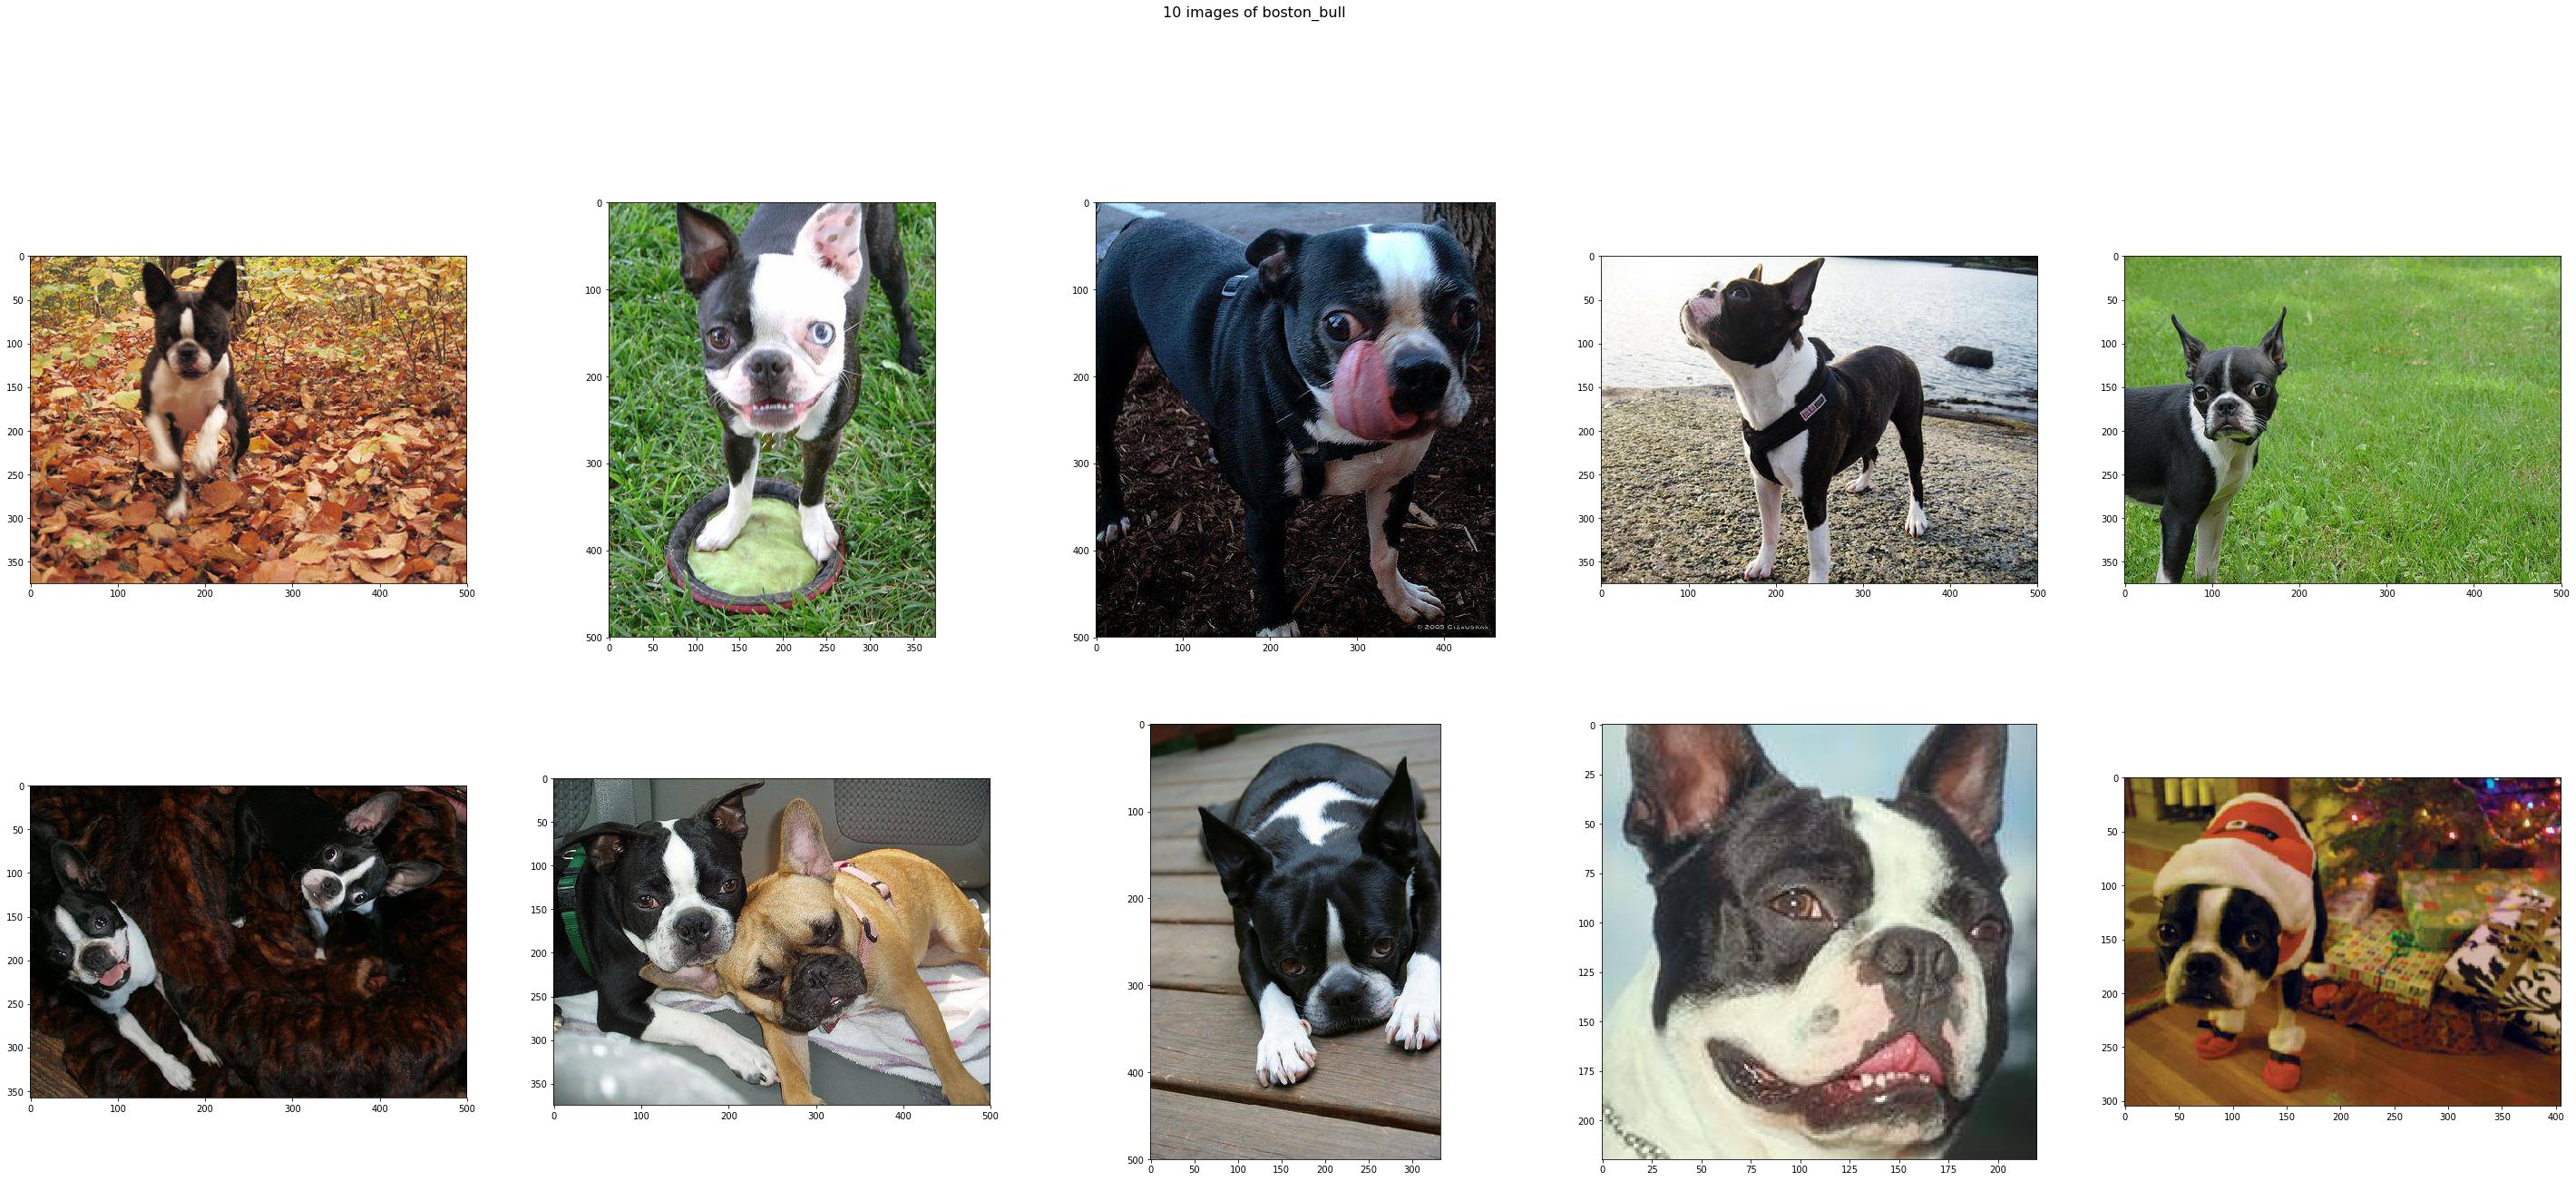

In [17]:
display_image(dog_breed="boston_bull")


In [18]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils
import glob
import cv2

from tqdm import tqdm
from keras.utils import np_utils
import glob
import cv2

In [19]:
!pip install keras

distributed 1.21.8 requires msgpack, which is not installed.
tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
coremltools 0.8 has requirement six==1.10.0, but you'll have six 1.11.0 which is incompatible.


# new model

In [20]:
import keras

In [21]:
from keras.preprocessing import image

In [22]:
import tensorflow as tf


In [ ]:
!ls {PATH}/train/339c285a763d61930b7c157c58a733f3.jpg

In [ ]:
#tf.keras.preprocessing.image.load_img(f"{PATH}/train/339c285a763d61930b7c157c58a733f3.jpg")

In [23]:
num_classes=120

In [24]:
!ls {PATH}/train/ |head -n 5

000bec180eb18c7604dcecc8fe0dba07.jpg
001513dfcb2ffafc82cccf4d8bbaba97.jpg
001cdf01b096e06d78e9e5112d419397.jpg
00214f311d5d2247d5dfe4fe24b2303d.jpg
0021f9ceb3235effd7fcde7f7538ed62.jpg
ls: write error: Broken pipe


In [25]:
print(f'{PATH}/train/')

/home/ubuntu/.kaggle/competitions/dog-breed-identification/train/


In [26]:
def load_images():
    x_train = []
    y_train = []
    im_size = 250

    i = 0 
    for f, breed in tqdm(labels_df.values):
        img = cv2.imread(f'{PATH}/train/{f}.jpg')
        label = one_hot_labels[i]
        x_train.append(cv2.resize(img, (im_size, im_size)))
        y_train.append(label)
        i += 1

  #x_train = np.array(x_train, np.uint8)
  #y_train = np.array(y_train, np.float32) / 255.
    x_train = np.array(x_train, np.float32) / 255.
    y_train = np.array(y_train, np.uint8) 
  
  
    return x_train, y_train

x_train, y_train = load_images()
print(x_train.shape)
print(y_train.shape)

100%|██████████| 10222/10222 [00:27<00:00, 375.01it/s]


(10222, 250, 250, 3)
(10222, 120)


In [27]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train
                                                      , test_size=0.3, random_state=1)


In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    vertical_flip=False,
    horizontal_flip=True)

train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, Y_train)




validation_generator = train_datagen.flow(X_valid
                                          , Y_valid)





In [29]:
im_size = 250
num_class = 120

In [30]:
# Create the base pre-trained model
# Can't download weights in the kernel
#base_model = VGG19(weights='imagenet',
#     include_top=False, input_shape=(im_size, im_size, 3))

base_model = ResNet50(weights='imagenet',
     include_top=False
                      , input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 125, 125, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 125, 125, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 125, 125, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
batch_size = 64


model.fit_generator(train_generator, train_generator.n//batch_size,
    epochs=20, workers=4, validation_data=validation_generator,
                    use_multiprocessing=True,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/20


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/keras/utils/data_utils.py", line 525, in _run
    with closing(self.executor_fn()) as executor:
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/keras/utils/data_utils.py", line 500, in <lambda>
    self.executor_fn = lambda: multiprocessing.Pool(workers)
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/multiprocessing/context.py", line 119, in Pool
    context=self.get_context())
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 174, in __init__
    self._repopulate_pool()
  File "/home/ubuntu/anaconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 239, 

In [ ]:

# fits the model on batches with real-time data augmentation:
model.fit_generator(transformer.flow(X_train, Y_train
                                     , batch_size=32),
                    steps_per_epoch=len(X_train) / 32
                    , shuffle = True
                    , epochs=epochs)

In [ ]:
model.fit(X_train
          , Y_train
          , epochs=20
          , validation_data=(X_valid, Y_valid), verbose=1)


In [ ]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.

In [ ]:
print(x_train_raw.shape)
print(y_train_raw.shape)


In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a new top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.core.debugger import set_trace
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from keras.models import  Model
from keras import optimizers
from os import makedirs
from os.path import join, exists, expanduser
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from sklearn.preprocessing import LabelBinarizer


In [ ]:
labels_df = pd.read_csv(PATH+"/labels.csv")
labels_df.head()

In [ ]:
encoder = LabelBinarizer()
one_hot_labels = encoder.fit_transform(labels_df['breed'])
print(one_hot_labels)

In [ ]:
def load_images():
  x_train = []
  y_train = []
  im_size = 250
  
  i = 0 
  for f, breed in tqdm(labels_df.values):
    img = cv2.imread(f'{PATH}/train/{f}.jpg')
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

  x_train = np.array(x_train, np.float32)
  y_train = np.array(y_train, np.uint8) 
  
  return x_train, y_train

x_train, y_train = load_images()
print(x_train.shape)
print(y_train.shape)

In [ ]:
IMG_WIDTH=250
IMG_Height=250
images=[]
classes=[]
targets_series = pd.Series(df_sub_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse=True)
one_hot_labels = np.asarray(one_hot)
i = 0
#load training images
for f, breed in tqdm(df_sub_train.values):
    img = cv2.imread('../input/dog-breed-identification/train/{}.jpg'.format(f))
    images.append(cv2.resize(img, (IMG_WIDTH, IMG_Height)))   
    label = one_hot_labels[i]
    classes.append(label)